In [1]:
import breizhcrops as bzh
from breizhcrops import BreizhCrops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import os
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score
import sklearn

In [2]:
frh01 = BreizhCrops("frh01")
frh02 = BreizhCrops("frh02")
frh03 = BreizhCrops("frh03")
frh04 = BreizhCrops("frh04")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
frh01.domain = 1
frh02.domain = 2
frh03.domain = 3
frh04.domain = 4

# Lengths and Shapes of Dataset

In [5]:
frh01[10][0].shape, frh01[10][1], frh01[10][2], len(frh01), len(frh02), len(frh03), len(frh04), len(frh01) + len(frh02) + len(frh03) + len(frh04)

(torch.Size([45, 13]),
 tensor(3),
 6022791,
 178613,
 140645,
 166391,
 122614,
 608263)

In [6]:
frh01[0] # returns x, y, field_id
frh01[13213][1] # label of 13213th observation 

tensor(7)

In [6]:
frh01[10][0].shape, frh01[10][1], frh01[10][2], len(frh01), len(frh02), len(frh03), len(frh04), len(frh01) + len(frh02) + len(frh03) + len(frh04)
print(f"Lenght of dataset1: {len(frh01)}\nLenght of dataset2: {len(frh02)}\nLenght of dataset3: {len(frh03)}\nLenght of dataset: {len(frh04)}\nTotal: {len(frh01) + len(frh02) + len(frh03) + len(frh04)}")

Lenght of dataset1: 178613
Lenght of dataset2: 140645
Lenght of dataset3: 166391
Lenght of dataset: 122614
Total: 608263


# DataLoader Function

In [4]:
def get_dataloader(mode, batchsize, num_workers=0):

    if mode == "evaluation" or mode == "evaluation1":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh03])
        testdataset = frh04
    elif mode == "evaluation2":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh04])
        testdataset = frh03
    elif mode == "evaluation3":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh03, frh04])
        testdataset = frh02
    elif mode == "evaluation4":
        traindatasets = torch.utils.data.ConcatDataset([frh02, frh03, frh04])
        testdataset = frh01
    elif mode == "validation":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        testdataset = frh03
    else:
        raise ValueError("only --mode 'validation' or 'evaluation' allowed")

    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=num_workers)
    testdataloader = DataLoader(testdataset, batch_size=batchsize, shuffle=False, num_workers=num_workers)

    meta = dict(
        ndims=13,
        num_classes=frh01.classes,
        sequencelength=45
    )

    return traindataloader, testdataloader, meta

# Sample Model

In [5]:
class LSTM_Model(torch.nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=4, output_size=9, bidirectional=False, dropout=0.2, c_norm=True):
        super(LSTM_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.c_norm = c_norm
        
        if num_layers > 1 and dropout > 0:
            self.dropout = dropout
        else:
            self.dropout = 0.0 
            
        self.clayernorm = nn.LayerNorm((hidden_size + hidden_size * bidirectional) * num_layers)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            bias=False, batch_first=True, dropout=dropout, bidirectional=bidirectional)   
        
        if bidirectional:
            hidden_size = hidden_size * 2
             
        self.fc = nn.Linear(hidden_size * num_layers, output_size, bias=True)
        
    def forward(self, x):
        
        outputs, last_state_list = self.lstm.forward(x)

        h, c = last_state_list

        nlayers, batchsize, n_hidden = c.shape
        
        if self.c_norm:
            x = self.clayernorm(c.transpose(0, 1).contiguous().view(batchsize, nlayers * n_hidden))
        else:
            x = c.transpose(0, 1).contiguous().view(batchsize, nlayers * n_hidden)
        x = self.fc.forward(x)
        return x
        
    def save(self, path="model.pth", **kwargs):
        print("\nsaving model to " + path)
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state, **kwargs), path)
        
model = LSTM_Model(input_size=13, hidden_size=128, num_layers=4, output_size=9, bidirectional=False, dropout=0.2, c_norm=True).to(device)


# Metrics - Train - Test Functions

In [6]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    recall_micro = recall_score(y_true, y_pred, average="micro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    precision_micro = precision_score(y_true, y_pred, average="micro")
    precision_macro = precision_score(y_true, y_pred, average="macro")
    precision_weighted = precision_score(y_true, y_pred, average="weighted")

    return dict(
        accuracy=accuracy,
        kappa=kappa,
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        f1_weighted=f1_weighted,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        recall_weighted=recall_weighted,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        precision_weighted=precision_weighted,
    )


def train_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    losses = list()
    with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
        for idx, batch in iterator:
            optimizer.zero_grad()
            x, y_true, _, _ = batch
            loss = criterion(model.forward(x.to(device)), y_true.to(device))
            loss.backward()
            optimizer.step()
            iterator.set_description(f"train loss={loss:.2f}")
            losses.append(loss)
    return torch.stack(losses)


def test_epoch(model, criterion, dataloader, device):
    model.eval()
    with torch.no_grad():
        losses = list()
        y_true_list = list()
        y_pred_list = list()
        field_ids_list = list()
        with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
            for idx, batch in iterator:
                x, y_true, field_id, _ = batch
                logits = model.forward(x.to(device))
                loss = criterion(logits, y_true.to(device))
                iterator.set_description(f"test loss={loss:.2f}")
                losses.append(loss)
                y_true_list.append(y_true)
                y_pred_list.append(logits.argmax(-1))
                field_ids_list.append(field_id)
        return torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list), torch.cat(field_ids_list)


In [7]:
train_dataloader, test_dataloader, meta = get_dataloader("evaluation1", batchsize=32, num_workers=4)

In [8]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = LSTM_Model(input_size=13, hidden_size=64, num_layers=2, output_size=9, bidirectional=False, dropout=0.2, c_norm=True).to(device)
train_dataloader, test_dataloader, meta = get_dataloader("evaluation1", batchsize=32, num_workers=0)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = Adam(model.parameters(), 0.001, weight_decay=1e-5)
log = list()
for epoch in range(10):
    train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, test_dataloader, device)
    scores1 = metrics(y_true.cpu(), y_pred.cpu())
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores1.items()])
    test_loss = test_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]
    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)

    scores1["epoch"] = epoch
    scores1["trainloss"] = train_loss
    scores1["testloss"] = test_loss
    log.append(scores1)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv("trainlog123.csv")

test loss=1.21: 100%|██████████| 3832/3832 [01:50<00:00, 34.55it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 0: trainloss 2.33, testloss 0.52 accuracy=0.75, kappa=0.67, f1_micro=0.75, f1_macro=0.50, f1_weighted=0.74, recall_micro=0.75, recall_macro=0.51, recall_weighted=0.75, precision_micro=0.75, precision_macro=0.51, precision_weighted=0.74


test loss=1.75: 100%|██████████| 3832/3832 [01:54<00:00, 33.54it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 1: trainloss 0.89, testloss 0.51 accuracy=0.77, kappa=0.69, f1_micro=0.77, f1_macro=0.54, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.53, precision_weighted=0.76


test loss=1.27: 100%|██████████| 3832/3832 [01:52<00:00, 34.06it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2: trainloss 0.43, testloss 0.64 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.53, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.55, precision_weighted=0.77


test loss=1.21: 100%|██████████| 3832/3832 [02:17<00:00, 27.87it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 3: trainloss 0.76, testloss 0.58 accuracy=0.78, kappa=0.71, f1_micro=0.78, f1_macro=0.54, f1_weighted=0.76, recall_micro=0.78, recall_macro=0.54, recall_weighted=0.78, precision_micro=0.78, precision_macro=0.55, precision_weighted=0.77


test loss=1.35: 100%|██████████| 3832/3832 [02:05<00:00, 30.46it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 4: trainloss 0.42, testloss 0.67 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.53, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.53, precision_weighted=0.76


train loss=0.42:  78%|███████▊  | 11906/15177 [15:13<04:10, 13.03it/s]


KeyboardInterrupt: 

In [74]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = LSTM_Model(input_size=13, hidden_size=64, num_layers=2, output_size=9, bidirectional=False, dropout=0.2, c_norm=True).to(device)
train_dataloader, test_dataloader, meta = get_dataloader("evaluation2", batchsize=32, num_workers=0)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = Adam(model.parameters(), 0.005, weight_decay=1e-6)
log = list()
for epoch in range(10):
    train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, test_dataloader, device)
    scores2 = metrics(y_true.cpu(), y_pred.cpu())
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores2.items()])
    test_loss = test_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]
    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)

    scores2["epoch"] = epoch
    scores2["trainloss"] = train_loss
    scores2["testloss"] = test_loss
    log.append(scores2)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv("trainlog124.csv")

test loss=1.11: 100%|██████████| 5200/5200 [03:35<00:00, 24.10it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 0: trainloss 2.35, testloss 0.79 accuracy=0.72, kappa=0.63, f1_micro=0.72, f1_macro=0.46, f1_weighted=0.68, recall_micro=0.72, recall_macro=0.50, recall_weighted=0.72, precision_micro=0.72, precision_macro=0.48, precision_weighted=0.72


test loss=1.01: 100%|██████████| 5200/5200 [03:33<00:00, 24.30it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 1: trainloss 0.52, testloss 0.41 accuracy=0.75, kappa=0.68, f1_micro=0.75, f1_macro=0.51, f1_weighted=0.74, recall_micro=0.75, recall_macro=0.53, recall_weighted=0.75, precision_micro=0.75, precision_macro=0.50, precision_weighted=0.74


test loss=0.99: 100%|██████████| 5200/5200 [03:34<00:00, 24.23it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2: trainloss 0.34, testloss 0.55 accuracy=0.76, kappa=0.69, f1_micro=0.76, f1_macro=0.53, f1_weighted=0.76, recall_micro=0.76, recall_macro=0.54, recall_weighted=0.76, precision_micro=0.76, precision_macro=0.53, precision_weighted=0.76


test loss=0.93: 100%|██████████| 5200/5200 [03:34<00:00, 24.29it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 3: trainloss 0.41, testloss 0.48 accuracy=0.75, kappa=0.67, f1_micro=0.75, f1_macro=0.50, f1_weighted=0.71, recall_micro=0.75, recall_macro=0.52, recall_weighted=0.75, precision_micro=0.75, precision_macro=0.52, precision_weighted=0.75


test loss=1.13: 100%|██████████| 5200/5200 [03:34<00:00, 24.24it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 4: trainloss 0.44, testloss 0.54 accuracy=0.77, kappa=0.69, f1_micro=0.77, f1_macro=0.51, f1_weighted=0.74, recall_micro=0.77, recall_macro=0.53, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.52, precision_weighted=0.76


test loss=1.06: 100%|██████████| 5200/5200 [03:34<00:00, 24.20it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 5: trainloss 0.57, testloss 0.51 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.53, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.53, precision_weighted=0.76


test loss=1.34: 100%|██████████| 5200/5200 [03:34<00:00, 24.27it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 6: trainloss 0.40, testloss 0.47 accuracy=0.77, kappa=0.69, f1_micro=0.77, f1_macro=0.52, f1_weighted=0.74, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.52, precision_weighted=0.75


test loss=0.91: 100%|██████████| 5200/5200 [03:33<00:00, 24.32it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 7: trainloss 0.36, testloss 0.43 accuracy=0.77, kappa=0.69, f1_micro=0.77, f1_macro=0.52, f1_weighted=0.74, recall_micro=0.77, recall_macro=0.53, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.54, precision_weighted=0.76


test loss=0.69: 100%|██████████| 5200/5200 [03:30<00:00, 24.65it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 8: trainloss 0.42, testloss 0.70 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.53, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.53, precision_weighted=0.76


test loss=0.89: 100%|██████████| 5200/5200 [03:34<00:00, 24.28it/s]


epoch 9: trainloss 0.58, testloss 0.38 accuracy=0.78, kappa=0.71, f1_micro=0.78, f1_macro=0.54, f1_weighted=0.76, recall_micro=0.78, recall_macro=0.55, recall_weighted=0.78, precision_micro=0.78, precision_macro=0.54, precision_weighted=0.76


/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = LSTM_Model(input_size=13, hidden_size=64, num_layers=2, output_size=9, bidirectional=False, dropout=0.2, c_norm=True).to(device)
train_dataloader, test_dataloader, meta = get_dataloader("evaluation3", batchsize=32, num_workers=0)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = Adam(model.parameters(), 0.005, weight_decay=1e-6)
log = list()
for epoch in range(10):
    train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, test_dataloader, device)
    scores3 = metrics(y_true.cpu(), y_pred.cpu())
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores3.items()])
    test_loss = test_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]
    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)

    scores3["epoch"] = epoch
    scores3["trainloss"] = train_loss
    scores3["testloss"] = test_loss
    log.append(scores3)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv("trainlog134.csv")

test loss=0.75: 100%|██████████| 4396/4396 [03:00<00:00, 24.40it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 0: trainloss 2.08, testloss 0.59 accuracy=0.75, kappa=0.67, f1_micro=0.75, f1_macro=0.51, f1_weighted=0.74, recall_micro=0.75, recall_macro=0.51, recall_weighted=0.75, precision_micro=0.75, precision_macro=0.53, precision_weighted=0.76


test loss=0.73: 100%|██████████| 4396/4396 [03:02<00:00, 24.08it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 1: trainloss 0.43, testloss 0.98 accuracy=0.75, kappa=0.67, f1_micro=0.75, f1_macro=0.53, f1_weighted=0.74, recall_micro=0.75, recall_macro=0.52, recall_weighted=0.75, precision_micro=0.75, precision_macro=0.55, precision_weighted=0.77


test loss=0.78: 100%|██████████| 4396/4396 [03:05<00:00, 23.76it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2: trainloss 0.85, testloss 0.86 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.54, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.55, precision_weighted=0.78


test loss=0.74: 100%|██████████| 4396/4396 [03:03<00:00, 23.95it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 3: trainloss 0.52, testloss 0.56 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.54, f1_weighted=0.77, recall_micro=0.77, recall_macro=0.53, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.56, precision_weighted=0.77


test loss=0.95: 100%|██████████| 4396/4396 [03:02<00:00, 24.15it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 4: trainloss 0.36, testloss 0.75 accuracy=0.74, kappa=0.66, f1_micro=0.74, f1_macro=0.52, f1_weighted=0.71, recall_micro=0.74, recall_macro=0.53, recall_weighted=0.74, precision_micro=0.74, precision_macro=0.57, precision_weighted=0.79


test loss=0.68: 100%|██████████| 4396/4396 [02:58<00:00, 24.63it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 5: trainloss 0.58, testloss 0.64 accuracy=0.78, kappa=0.71, f1_micro=0.78, f1_macro=0.55, f1_weighted=0.77, recall_micro=0.78, recall_macro=0.55, recall_weighted=0.78, precision_micro=0.78, precision_macro=0.56, precision_weighted=0.78


test loss=0.57: 100%|██████████| 4396/4396 [03:10<00:00, 23.04it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 6: trainloss 0.48, testloss 0.59 accuracy=0.78, kappa=0.71, f1_micro=0.78, f1_macro=0.55, f1_weighted=0.78, recall_micro=0.78, recall_macro=0.55, recall_weighted=0.78, precision_micro=0.78, precision_macro=0.57, precision_weighted=0.78


test loss=0.65: 100%|██████████| 4396/4396 [03:06<00:00, 23.51it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 7: trainloss 0.35, testloss 0.53 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.55, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.57, precision_weighted=0.79


test loss=0.72: 100%|██████████| 4396/4396 [03:08<00:00, 23.29it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 8: trainloss 0.38, testloss 0.65 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.54, f1_weighted=0.76, recall_micro=0.77, recall_macro=0.54, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.57, precision_weighted=0.79


test loss=0.66: 100%|██████████| 4396/4396 [03:09<00:00, 23.25it/s]


epoch 9: trainloss 0.36, testloss 0.66 accuracy=0.78, kappa=0.72, f1_micro=0.78, f1_macro=0.55, f1_weighted=0.78, recall_micro=0.78, recall_macro=0.54, recall_weighted=0.78, precision_micro=0.78, precision_macro=0.57, precision_weighted=0.78


/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = LSTM_Model(input_size=13, hidden_size=64, num_layers=2, output_size=9, bidirectional=False, dropout=0.2, c_norm=True).to(device)
train_dataloader, test_dataloader, meta = get_dataloader("evaluation4", batchsize=32, num_workers=0)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = Adam(model.parameters(), 0.005, weight_decay=1e-6)
log = list()
for epoch in range(10):
    train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, test_dataloader, device)
    scores4 = metrics(y_true.cpu(), y_pred.cpu())
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores4.items()])
    test_loss = test_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]
    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)

    scores4["epoch"] = epoch
    scores4["trainloss"] = train_loss
    scores4["testloss"] = test_loss
    log.append(scores4)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv("trainlog234.csv")

test loss=0.92: 100%|██████████| 5582/5582 [03:53<00:00, 23.89it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 0: trainloss 2.77, testloss 0.31 accuracy=0.77, kappa=0.70, f1_micro=0.77, f1_macro=0.53, f1_weighted=0.77, recall_micro=0.77, recall_macro=0.52, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.55, precision_weighted=0.77


test loss=1.70: 100%|██████████| 5582/5582 [04:10<00:00, 22.25it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 1: trainloss 0.66, testloss 0.32 accuracy=0.79, kappa=0.73, f1_micro=0.79, f1_macro=0.54, f1_weighted=0.78, recall_micro=0.79, recall_macro=0.53, recall_weighted=0.79, precision_micro=0.79, precision_macro=0.55, precision_weighted=0.78


test loss=0.98: 100%|██████████| 5582/5582 [04:24<00:00, 21.13it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2: trainloss 0.69, testloss 0.32 accuracy=0.79, kappa=0.73, f1_micro=0.79, f1_macro=0.54, f1_weighted=0.79, recall_micro=0.79, recall_macro=0.54, recall_weighted=0.79, precision_micro=0.79, precision_macro=0.55, precision_weighted=0.79


test loss=0.87: 100%|██████████| 5582/5582 [04:19<00:00, 21.48it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 3: trainloss 0.57, testloss 0.28 accuracy=0.77, kappa=0.72, f1_micro=0.77, f1_macro=0.55, f1_weighted=0.77, recall_micro=0.77, recall_macro=0.55, recall_weighted=0.77, precision_micro=0.77, precision_macro=0.55, precision_weighted=0.80


test loss=1.19: 100%|██████████| 5582/5582 [04:20<00:00, 21.46it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 4: trainloss 0.45, testloss 0.25 accuracy=0.79, kappa=0.73, f1_micro=0.79, f1_macro=0.55, f1_weighted=0.79, recall_micro=0.79, recall_macro=0.55, recall_weighted=0.79, precision_micro=0.79, precision_macro=0.55, precision_weighted=0.79


test loss=1.14: 100%|██████████| 5582/5582 [49:53<00:00,  1.86it/s]    
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 5: trainloss 0.60, testloss 0.28 accuracy=0.80, kappa=0.75, f1_micro=0.80, f1_macro=0.56, f1_weighted=0.80, recall_micro=0.80, recall_macro=0.55, recall_weighted=0.80, precision_micro=0.80, precision_macro=0.56, precision_weighted=0.80


test loss=0.75: 100%|██████████| 5582/5582 [03:42<00:00, 25.12it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 6: trainloss 0.40, testloss 0.29 accuracy=0.81, kappa=0.75, f1_micro=0.81, f1_macro=0.56, f1_weighted=0.80, recall_micro=0.81, recall_macro=0.55, recall_weighted=0.81, precision_micro=0.81, precision_macro=0.57, precision_weighted=0.80


test loss=1.01: 100%|██████████| 5582/5582 [03:56<00:00, 23.61it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 7: trainloss 0.32, testloss 0.31 accuracy=0.80, kappa=0.75, f1_micro=0.80, f1_macro=0.56, f1_weighted=0.80, recall_micro=0.80, recall_macro=0.56, recall_weighted=0.80, precision_micro=0.80, precision_macro=0.56, precision_weighted=0.81


test loss=0.90: 100%|██████████| 5582/5582 [04:21<00:00, 21.38it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 8: trainloss 0.46, testloss 0.33 accuracy=0.79, kappa=0.74, f1_micro=0.79, f1_macro=0.55, f1_weighted=0.79, recall_micro=0.79, recall_macro=0.55, recall_weighted=0.79, precision_micro=0.79, precision_macro=0.55, precision_weighted=0.80


test loss=1.00: 100%|██████████| 5582/5582 [03:56<00:00, 23.57it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 9: trainloss 0.53, testloss 0.34 accuracy=0.80, kappa=0.74, f1_micro=0.80, f1_macro=0.56, f1_weighted=0.80, recall_micro=0.80, recall_macro=0.56, recall_weighted=0.80, precision_micro=0.80, precision_macro=0.56, precision_weighted=0.80


# Dummy Model Training

In [61]:
# Take small part of fh01 for training
small_frh01 = torch.utils.data.Subset(frh01, range(0, 1000))
# Train - test split
import sklearn.model_selection
train_indices, test_indices = sklearn.model_selection.train_test_split(range(len(small_frh01)), test_size=0.2)
train_dataset = torch.utils.data.Subset(small_frh01, train_indices)
test_dataset = torch.utils.data.Subset(small_frh01, test_indices)
train_dataloader1 = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader1 = DataLoader(test_dataset, batch_size=8, shuffle=False)
dummy_model = LSTM_Model(input_size=13, hidden_size=64, num_layers=4, output_size=9, bidirectional=False, dropout=0, c_norm=False).to(device)
criterion1 = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer1 = Adam(dummy_model.parameters(), 0.005, weight_decay=1e-6)


In [67]:
log = list()
for epoch in range(5):
    train_loss = train_epoch(dummy_model, optimizer1, criterion1, train_dataloader1, device)
    test_loss, y_true, y_pred, *_ = test_epoch(dummy_model, criterion1, test_dataloader1, device)
    scores1 = metrics(y_true.cpu(), y_pred.cpu())
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    test_loss = test_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]
    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)

    scores["epoch"] = epoch
    scores["trainloss"] = train_loss
    scores["testloss"] = test_loss
    log.append(scores)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv("trainlog.csv")

test loss=1.48: 100%|██████████| 25/25 [00:00<00:00, 54.17it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 0: trainloss 1.44, testloss 1.40 accuracy=0.41, kappa=0.15, f1_micro=0.41, f1_macro=0.15, f1_weighted=0.31, recall_micro=0.41, recall_macro=0.19, recall_weighted=0.41, precision_micro=0.41, precision_macro=0.12, precision_weighted=0.25, epoch=9.00, trainloss=1.68, testloss=1.33


test loss=1.57: 100%|██████████| 25/25 [00:00<00:00, 56.76it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 1: trainloss 1.38, testloss 1.32 accuracy=0.41, kappa=0.15, f1_micro=0.41, f1_macro=0.15, f1_weighted=0.31, recall_micro=0.41, recall_macro=0.19, recall_weighted=0.41, precision_micro=0.41, precision_macro=0.12, precision_weighted=0.25, epoch=0.00, trainloss=1.44, testloss=1.40


test loss=1.50: 100%|██████████| 25/25 [00:00<00:00, 54.38it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2: trainloss 1.66, testloss 1.47 accuracy=0.41, kappa=0.15, f1_micro=0.41, f1_macro=0.15, f1_weighted=0.31, recall_micro=0.41, recall_macro=0.19, recall_weighted=0.41, precision_micro=0.41, precision_macro=0.12, precision_weighted=0.25, epoch=1.00, trainloss=1.38, testloss=1.32


test loss=1.43: 100%|██████████| 25/25 [00:00<00:00, 51.78it/s]
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 3: trainloss 1.86, testloss 1.41 accuracy=0.41, kappa=0.15, f1_micro=0.41, f1_macro=0.15, f1_weighted=0.31, recall_micro=0.41, recall_macro=0.19, recall_weighted=0.41, precision_micro=0.41, precision_macro=0.12, precision_weighted=0.25, epoch=2.00, trainloss=1.66, testloss=1.47


test loss=1.52: 100%|██████████| 25/25 [00:00<00:00, 53.62it/s]

epoch 4: trainloss 1.54, testloss 1.48 accuracy=0.41, kappa=0.15, f1_micro=0.41, f1_macro=0.15, f1_weighted=0.31, recall_micro=0.41, recall_macro=0.19, recall_weighted=0.41, precision_micro=0.41, precision_macro=0.12, precision_weighted=0.25, epoch=3.00, trainloss=1.86, testloss=1.41



/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
df123 = pd.read_csv("csv/A/trainlog123.csv")
df124 = pd.read_csv("csv/A/trainlog124.csv")
df134 = pd.read_csv("csv/A/trainlog134.csv")
df234 = pd.read_csv("csv/A/trainlog234.csv")
df_result = pd.read_csv("csv/A/results_A.csv")

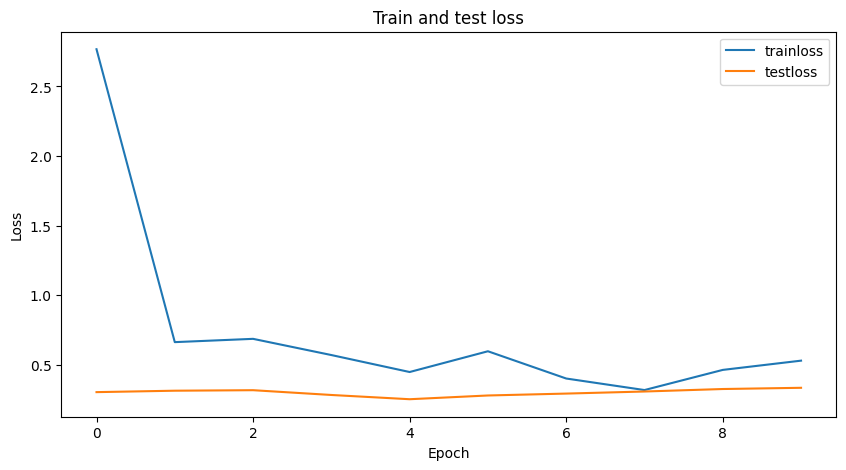

In [7]:
# Plot trainloss and testloss
figura, ax = plt.subplots(1, 1, figsize=(10, 5))
df234[["trainloss", "testloss"]].plot(ax=ax)
ax.set_title("Train and test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()


In [9]:
df_result

,dataset,trainloss,testloss,accuracy,f1_weighted,kappa
0,123,0.404567,0.723069,0.779715,0.775991,0.713967
1,124,0.578021,0.376704,0.778504,0.763583,0.708118
2,134,0.364634,0.657537,0.781556,0.779226,0.715002
3,234,0.531347,0.336519,0.798453,0.797201,0.744449
